In [9]:
import pandas as pd
import random
import spacy
from utilities.utils import *
import concurrent.futures
nlp = spacy.load("de_core_news_lg")
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from typing import List, Tuple
import re
import collections
from multiprocessing import Pool
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import re
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

## Compare vocabs

In [2]:
def process_sentence(sentence):
    # Remove punctuation and digits
    sentence = re.sub(r'[^\w\s]', '', str(sentence))  # Remove punctuation
    sentence = re.sub(r'\d', '', sentence)  # Remove digits

    # Lowercase and split the sentence into words
    words = sentence.lower().split()

    return words


def top_words(sentences):
    # Initialize a list to hold all words
    all_words = []

    with Pool() as p:
        # Process sentences concurrently
        words_lists = p.map(process_sentence, sentences)

        # Add words to the list
        for words in words_lists:
            all_words.extend(words)

    # Use collections.Counter to get word frequencies
    word_counts = collections.Counter(all_words)

    # Get the top 25 words
    top_25_words = word_counts.most_common(25)

    # Calculate the total number of words
    total_words = len(all_words)

    # Convert the word counts to shares
    top_25_words_shares = [(word, count / total_words) for word, count in top_25_words]

    return top_25_words_shares

In [16]:
nltk.download('stopwords')
german_stop_words = set(stopwords.words('german'))


def count_words_parallel(sentences):
    # Splitting sentences into words and removing punctuation, special characters and digits
    words_lists = [re.sub('[^A-Za-zäöüßÄÖÜ]+', ' ', str(sentence)).lower().split() for sentence in sentences]
    
    # Flatten the list of words and remove stopwords
    words = [
        word for words_list in words_lists for word in words_list if word not in german_stop_words
    ]

    # Count the occurrences of each word
    word_counts = Counter(words)

    # Get the most common 25 words
    top_25_words = word_counts.most_common(25)

    # Calculate the share of these words in all words
    total_word_count = len(words)
    word_shares = [(word, count / total_word_count) for word, count in top_25_words]

    return word_shares


def parallel_count_words(sentences, n_jobs=4):
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        # split sentences into n_jobs parts
        sentence_parts = np.array_split(sentences, n_jobs)
        results = list(executor.map(count_words_parallel, sentence_parts))
    # combine the results
    all_word_shares = [word_share for result in results for word_share in result]
    df = pd.DataFrame(all_word_shares,columns=['Word','Share'])
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


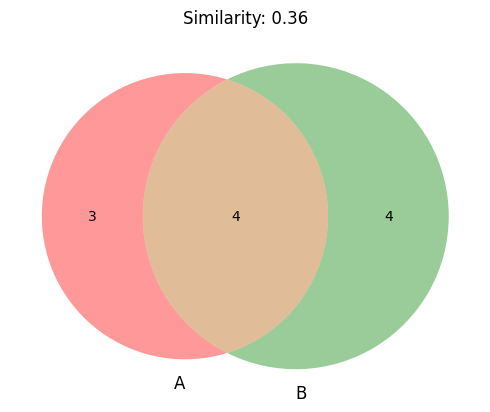

Similarity: 0.36
Intersection size: 4


In [4]:

def preprocess_string(s: str) -> List[str]:
    # Split the string into sentences, then split each sentence into words
    words = re.findall(r'\b\w+\b', s)
    return words


def similarity_and_venn_diagram(strings_a: List[str], strings_b: List[str]) -> Tuple[float, float]:
    words_a = {word for s in strings_a for word in preprocess_string(s)}
    words_b = {word for s in strings_b for word in preprocess_string(s)}

    intersection = words_a.intersection(words_b)
    union = words_a.union(words_b)

    similarity = len(intersection) / len(union)

    plt.figure()
    venn2([words_a, words_b], set_labels=('A', 'B'))
    plt.title(f"Similarity: {similarity:.2f}")
    plt.show()

    return similarity, len(intersection)

    return data

# Example lists of strings
strings_a = ["This is the first sentence. Here is another sentence."]
strings_b = ["This is a different sentence. And another different one."]

similarity, intersection_size = similarity_and_venn_diagram(strings_a, strings_b)
print(f"Similarity: {similarity:.2f}")
print(f"Intersection size: {intersection_size}")


In [6]:

def plot_similarity_heatmap(similarity_matrix, labels):
    # Make a copy of the similarity matrix to avoid modifying the original
    similarity_matrix_copy = np.copy(similarity_matrix)

    # Set diagonal elements to NaN
    np.fill_diagonal(similarity_matrix_copy, np.nan)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(similarity_matrix_copy,
                     annot=True,
                     cmap="YlGnBu",
                     linewidths=0.5,
                     xticklabels=labels,
                     yticklabels=labels,
                     mask=np.isnan(similarity_matrix_copy))
    ax.set_title("Cosine Similarity")
    plt.show()

In [19]:
def calculate_cosine_similarity(df1, df2, df3, df4):
    # Combine the dataframes into a list
    dfs = [df1, df2, df3, df4]
    
    # Merge the dataframes and fill missing values with zeros
    merged_df = pd.concat(dfs, axis=0, keys=range(len(dfs)), names=["df_idx"])
    merged_df = merged_df.reset_index(level="df_idx").pivot_table(values="Share",
                                                                  index="Word",
                                                                  columns="df_idx",
                                                                  fill_value=0)

    # Calculate the pairwise cosine similarity
    similarities = cosine_similarity(merged_df.T)

    return similarities

In [7]:
# define a function to read JSON file and return data
def read_json_file(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data


# initialize an empty DataFrame
df = pd.DataFrame()

# specify the directory where JSON files are stored
dir_path = "data/data_files/fang-covid/articles/"
temp_df = pd.DataFrame()
source_arr = []
date_arr = []
article_arr = []
label_arr = []
# loop over all JSON files in the directory
for filename in os.listdir(dir_path):
    if filename.endswith('.json'):
        full_filename = os.path.join(dir_path, filename)

        f = open(full_filename)
        single_fang = json.load(f)
        f.close()

        # append data to DataFrame
        source_arr.append(single_fang['source'])
        date_arr.append(single_fang['date'])
        article_arr.append(single_fang['article'])
        label_arr.append(single_fang['label'])

df['Publisher'] = source_arr
df['Date'] = date_arr
df['Article'] = article_arr
df['Veracity'] = label_arr
df['word_count'] = np.array(df['Article'].apply(lambda x: len(str(x).split())))

# keep only 'source', 'date', 'label' and 'article'
# df = df[['source', 'date', 'label', 'article']]

In [8]:
whole_dict = {
    'protected': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/protected_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/protected_articles/0_protected_titles.csv')
    },
    'excellent': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/excellent_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/excellent_articles/0_excellent_titles.csv')
    },
    'readworthy': {
        'df':
        pd.read_csv(
            f'data/data_files/pipeline_steps/readworthy_articles/1_all_articles_fetched.csv'),
        'titles':
        pd.read_csv(f'data/data_files/pipeline_steps/readworthy_articles/0_readworthy_titles.csv')
    },
}


In [ ]:
for key, value in whole_dict.items():

    whole_dict['word_count']=(parallel_count_words(value['df']['sub_texts']))

In [17]:
a = parallel_count_words(whole_dict['protected']['df']['sub_texts'])


In [18]:
a

,Word,Share
0,wurde,0.007979
1,wurden,0.003935
2,etwa,0.002305
3,jedoch,0.002203
4,ab,0.002019
...,...,...
95,beim,0.001269
96,dabei,0.001259
97,teil,0.001223
98,später,0.001166


In [33]:
def create_dataframe(list1, list2, list3, list4):
    # Create DataFrame from each list

    df2 = pd.DataFrame(list2, columns=['Protected', 'share2'])
    df3 = pd.DataFrame(list3, columns=['Excellent', 'share3'])
    df4 = pd.DataFrame(list4, columns=['Readworthy', 'share4'])
    df1 = pd.DataFrame(list1, columns=['FANG', 'share1'])
    # Concatenate all dataframes along the column axis
    df = pd.concat([df1, df2, df3, df4], axis=1)

    return df

In [38]:
a =parallel_count_words(whole_dict['protected']['df']['sub_texts'])
len(a)

100

In [30]:
parallel_count_words(df['Article'])
print(parallel_count_words(df['Article']))

[('corona', 0.005965045719823745), ('mehr', 0.005105631250299725), ('menschen', 0.004305771326159278), ('sei', 0.0031084349979981197), ('schon', 0.0029360167823370585), ('zeit', 0.0025331871607537776), ('viele', 0.0025249342836781512), ('wurde', 0.0025017370075736877), ('immer', 0.0024129628163277596), ('gibt', 0.00240270248266617), ('pandemie', 0.002384858424124275), ('prozent', 0.0023786130036346116), ('sagte', 0.002337571668988253), ('sagt', 0.00228961576165691), ('deutschland', 0.0022684259421384095), ('seit', 0.002256158151890857), ('müssen', 0.0019171210395948505), ('virus', 0.0018221014278592595), ('zwei', 0.0017732533176008218), ('krise', 0.0017612085780850425), ('bereits', 0.001740910961493637), ('wurden', 0.001727974019050763), ('coronavirus', 0.0016847021770866675), ('etwa', 0.001681579466841836), ('geht', 0.0016739957419615304), ('corona', 0.005828480016559588), ('mehr', 0.005010625360694153), ('menschen', 0.004311342755348961), ('sei', 0.003101097860190728), ('schon', 0.00

In [34]:
result_df = create_dataframe(
    parallel_count_words(whole_dict['protected']['df']['sub_texts']), 
    parallel_count_words(whole_dict['excellent']['df']['sub_texts']),
    parallel_count_words(whole_dict['readworthy']['df']['sub_texts']),
    parallel_count_words(df['Article'])
    )


In [ ]:
parallel_count_words(whole_dict['protected']['df']['sub_texts']), 
parallel_count_words(whole_dict['excellent']['df']['sub_texts']),
parallel_count_words(whole_dict['readworthy']['df']['sub_texts']),
parallel_count_words(df['Article'])

In [36]:
result_df.to_clipboard()

PyperclipException: 
    Pyperclip could not find a copy/paste mechanism for your system.
    For more information, please visit
    https://pyperclip.readthedocs.io/en/latest/#not-implemented-error
    

In [42]:
result_df.head(10)

,FANG,share1,Protected,share2,Excellent,share3,Readworthy,share4
0,wurde,0.007979,wurde,0.010972,wurde,0.012012,corona,0.005965
1,wurden,0.003935,wurden,0.004761,wurden,0.005361,mehr,0.005106
2,etwa,0.002305,stadt,0.003405,stadt,0.004264,menschen,0.004306
3,jedoch,0.002203,jahr,0.002599,seit,0.002726,sei,0.003108
4,ab,0.002019,seit,0.002446,jahr,0.002693,schon,0.002936
5,seit,0.001972,zeit,0.002310,sowie,0.002427,zeit,0.002533
6,sowie,0.001945,jedoch,0.002168,etwa,0.002340,viele,0.002525
7,mehr,0.001797,sowie,0.002156,ab,0.002305,wurde,0.002502
8,menschen,0.001795,jahre,0.002155,zeit,0.002194,immer,0.002413
9,zeit,0.001793,etwa,0.002153,jahre,0.002145,gibt,0.002403


In [20]:
b = calculate_cosine_similarity(parallel_count_words(whole_dict['protected']['df']['sub_texts']), 
parallel_count_words(whole_dict['excellent']['df']['sub_texts']),
parallel_count_words(whole_dict['readworthy']['df']['sub_texts']),
parallel_count_words(df['Article']))

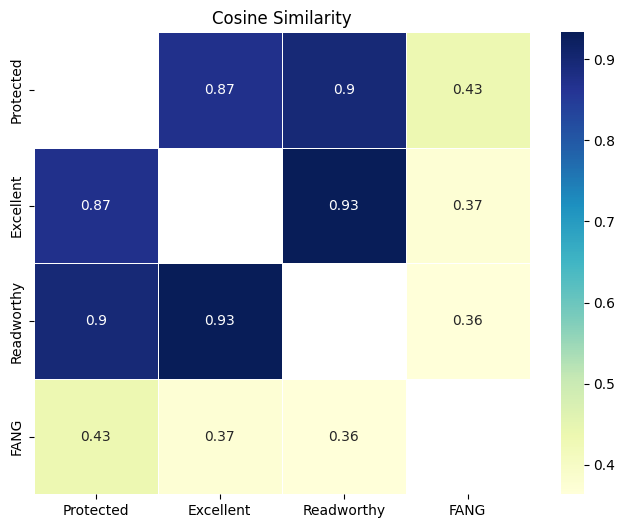

In [22]:
plot_similarity_heatmap(b,['Protected','Excellent','Readworthy','FANG'])